In [1]:
import cv2
import h5py
import copy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [29]:
np.random.seed(123)

In [2]:
FIG_REG_WIDTH = 7
FIG_REG_ASPECT_RATIO = 1.75

def set_fig_settings(fig_size=(48,48), font_size=16, font_scale=1.6):       
    plt.rcParams['figure.figsize'] = fig_size
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams["legend.framealpha"] = 0

    font = {'weight' : 'normal', 'size'   : font_size}

    plt.rc('font', **font)

In [3]:
TEST_DATASET_PATH = 'uci_ml_hackathon_fire_dataset_2013-01-01_2014-01-01_5k_test.hdf5'

def getData():
    with h5py.File(TEST_DATASET_PATH, 'r') as f:
        test_data = {}
        for k in list(f):
            test_data[k] = f[k][:]
    large_fire_inds = np.where(
        (np.sum(test_data['observed'][:,0],axis=(1,2)) > 50) & 
        (np.sum(test_data['observed'][:,1],axis=(1,2)) > 50) & 
        (np.sum(test_data['observed'][:,2],axis=(1,2)) > 50) & 
        (np.sum(test_data['observed'][:,3],axis=(1,2)) > 50) & 
        (np.sum(test_data['observed'][:,4],axis=(1,2)) > 50) & 
        (np.sum(test_data['target'][:,0],axis=(1,2)) > 50) 
    )[0]
    return test_data, large_fire_inds

In [4]:
CKPT_FILE_FULL = './24hrs-model/checkpoints/weights.03-0.33.h5'
CKPT_FILE_HALF = './checkpoints/weights.10-0.16-0.95.h5'

In [5]:
model_full = load_model(CKPT_FILE_FULL)
model_half = load_model(CKPT_FILE_HALF)

In [6]:
def standardizeData(data):
	np.nan_to_num(data,copy=False)
	print("New Set: ",np.mean(data),np.std(data),np.min(data),np.max(data))
	for i in range(data.shape[-1]):
		dim = data[:,:,:,i]
		mean = np.mean(dim)
		std = np.std(dim)
		if int(mean)>0 and int(std)>0:
			print(i,mean,std)
			dim = dim-mean
			dim = dim/std
			data[:,:,:,i] = dim

	print(np.mean(data),np.std(data),np.min(data),np.max(data))
	print("----------------------------------\n\n")
	return data

def preprocessData(data):
	geographical_data = data['land_cover']
	geographical_data = np.moveaxis(geographical_data,1,3)
	geographical_data = standardizeData(geographical_data)
	weather_data = data['meteorology'][:,0,:,:,:]
	weather_data_12 = data['meteorology'][:,1,:,:,:]
	weather_data = np.moveaxis(weather_data,1,3)
	weather_data = standardizeData(weather_data)
	weather_data_12 = np.moveaxis(weather_data,1,3)
	weather_data_12 = standardizeData(weather_data)
	image_data = data['observed']
	image_data = np.moveaxis(image_data,1,3)
	image_data = standardizeData(image_data)
	training_data = [image_data,geographical_data,weather_data,weather_data_12]
	ground_truth = data['target'][:,0,:,:]
	ground_truth_12 = data['target'][:,1,:,:]
	return (training_data, ground_truth, ground_truth_12)

In [7]:
def prepareDataset(task_mode="classification",timestep="12"):
    test_data,inds = getData()
    X_test,Y_test, Y_test_12 = preprocessData(test_data)
    for i in range(len(X_test)):
        X_test[i] = X_test[i][inds]
    return (X_test,Y_test[inds],Y_test_12[inds], inds)

In [8]:
(X_test,Y_test,Y_test_12,inds) = prepareDataset()

New Set:  100.79079 342.90274 -70.7456 3719.6465
0 161.00198 87.006226
1 5.623755 4.4029255
2 14.472052 17.69847
3 34.93967 21.979824
4 199.38481 128.90744
5 1281.625 660.7324
16 15.386592 9.949932
0.05882355 0.6742513 -2.046775 7.722557
----------------------------------


New Set:  66.50477345016 114.24292305522789 -10.749191284179688 318.65576171875
0 292.0823406540934 8.33720650441378
1 40.50194644444444 18.32658089558619
-0.012083969547580033 1.7763502923361956 -35.033597944282995 13.852105140686035
----------------------------------


New Set:  -0.012083969547580033 1.7763502923361956 -35.033597944282995 13.852105140686035
-0.012083969547580033 1.7763502923361956 -35.033597944282995 13.852105140686035
----------------------------------


New Set:  0.04794631111111111 0.21365266757508028 0 1
0.04794631111111111 0.21365266757508028 0 1
----------------------------------




In [9]:
preds_full = model_full.predict(X_test)
preds_half = model_half.predict(X_test)

In [18]:
test_img_pred_full = preds_full[0][0]
test_img_pred_half = preds_half[0]
test_img = Y_test[0]

In [71]:
random_idx = np.random.choice(range(preds_half.shape[0]),size=10,replace=False)

In [72]:
preds_full_slice = preds_full[0][random_idx]
preds_half_slice = preds_half[random_idx]
g_truth = Y_test[random_idx]

## Samples of T=+12 predictions

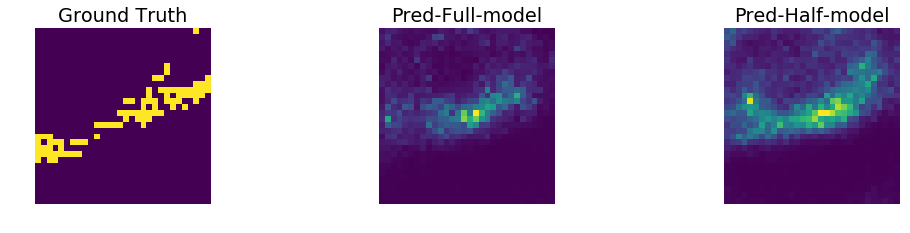

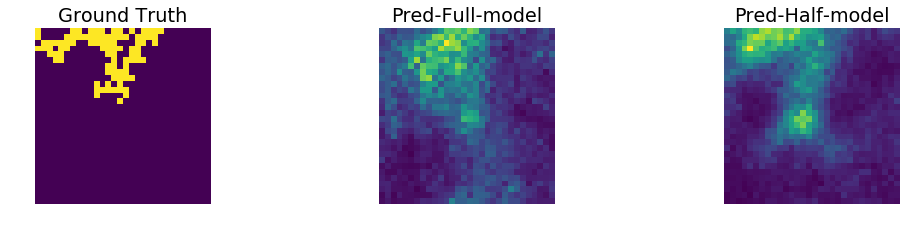

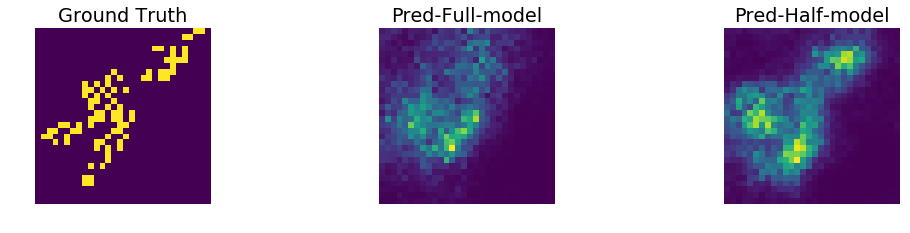

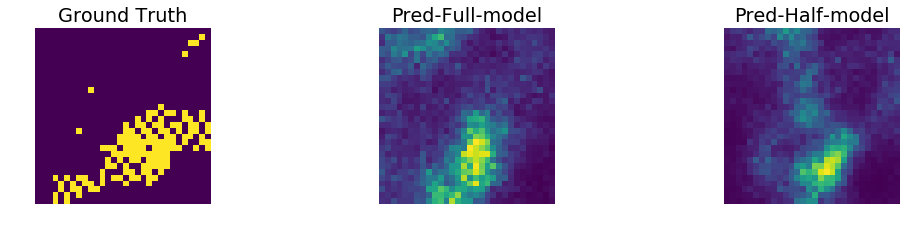

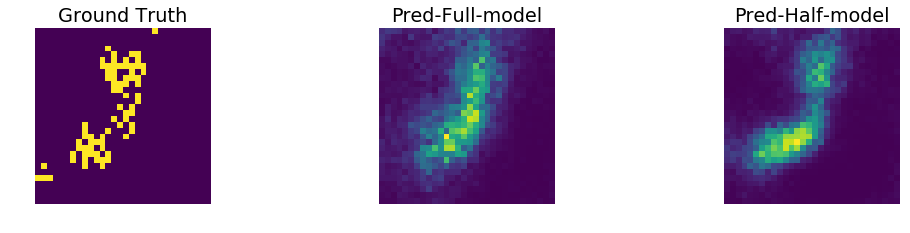

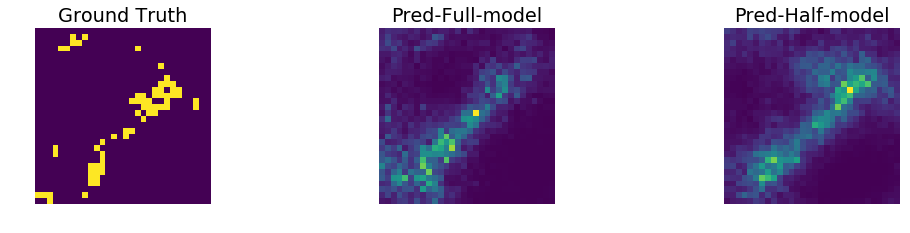

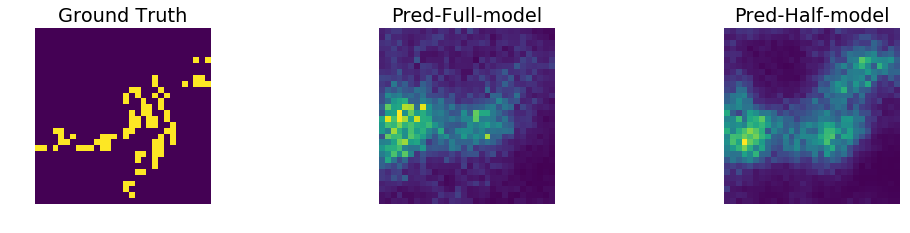

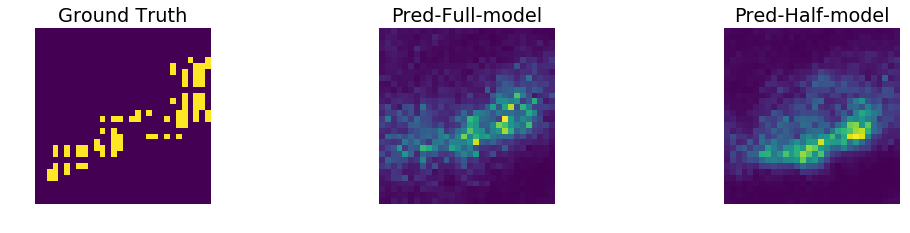

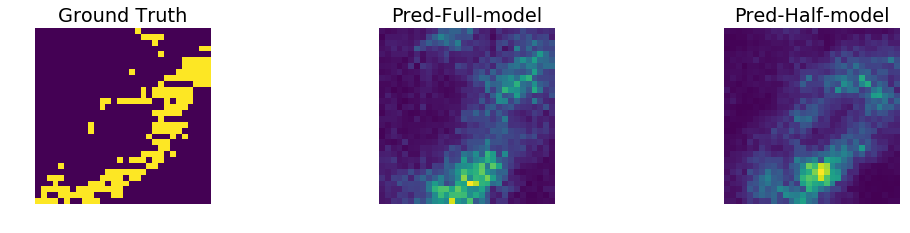

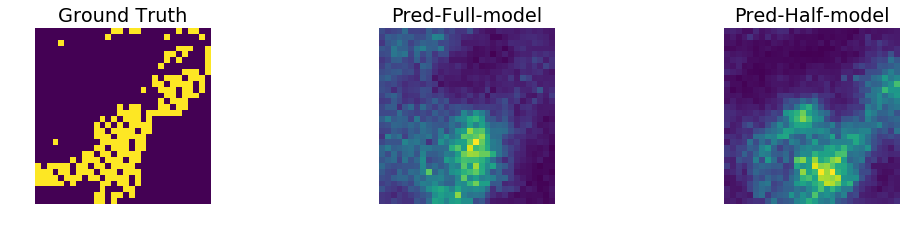

In [73]:
set_fig_settings((FIG_REG_WIDTH*2.5,FIG_REG_WIDTH*5.45))
fig = plt.figure()

for i in range(10):    
    plt.subplot(10,3,1)
    plt.imshow(g_truth[i])
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(10,3,2)
    plt.imshow(preds_full_slice[i])
    plt.title('Pred-Full-model')
    plt.axis('off')

    plt.subplot(10,3,3)
    plt.imshow(preds_half_slice[i])
    plt.title('Pred-Half-model')
    plt.axis('off')
    plt.show()


In [74]:
preds_full_slice = preds_full[1][random_idx]
g_truth = Y_test_12[random_idx]

## Samples of T=+24 predictions

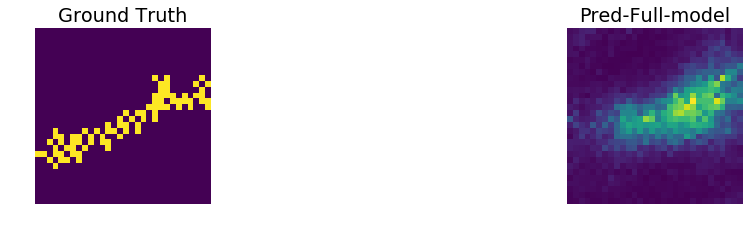

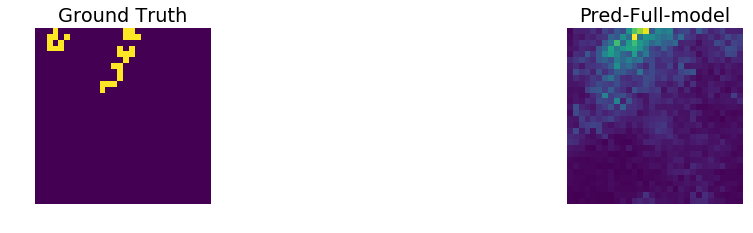

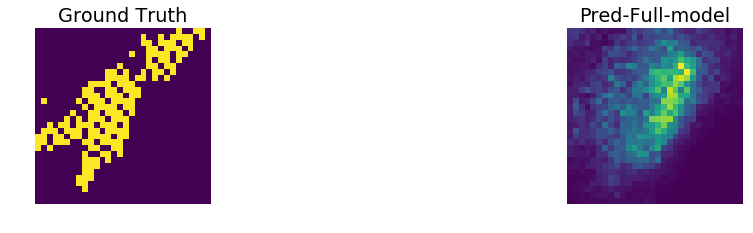

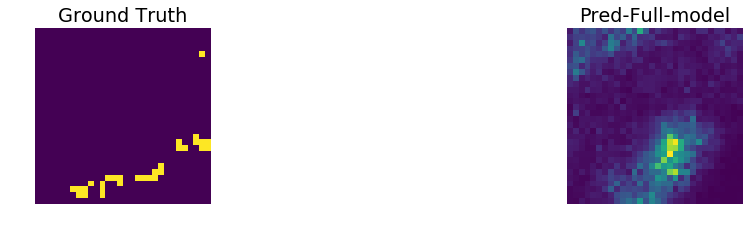

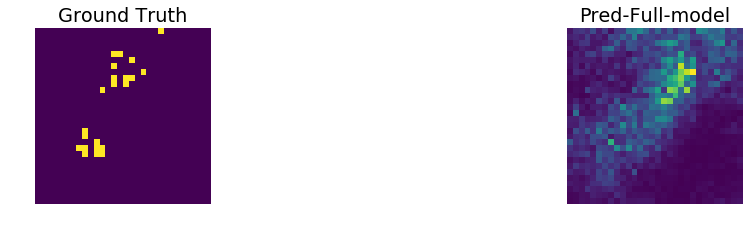

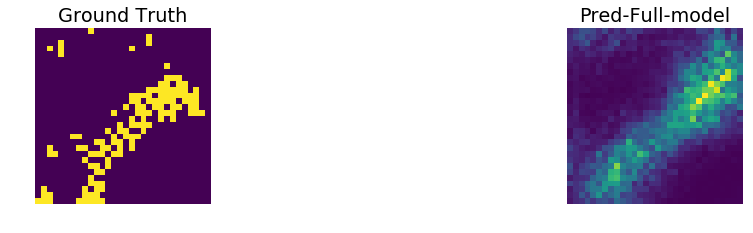

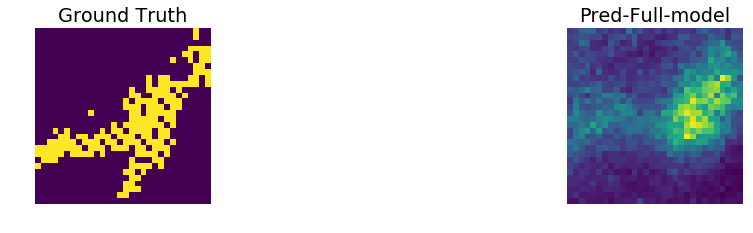

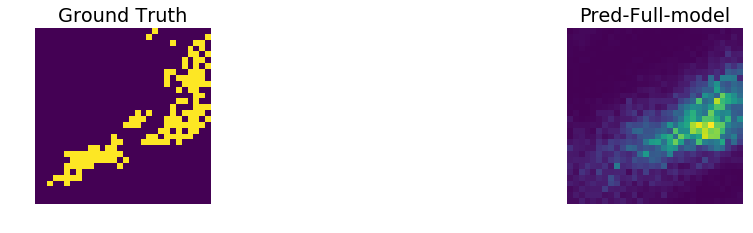

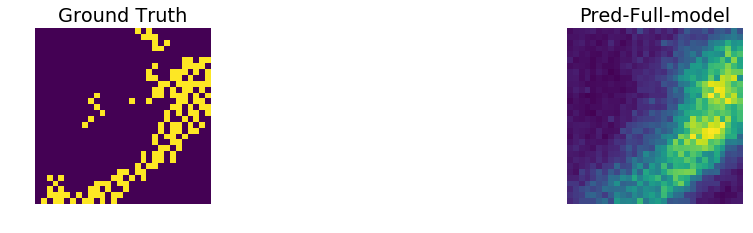

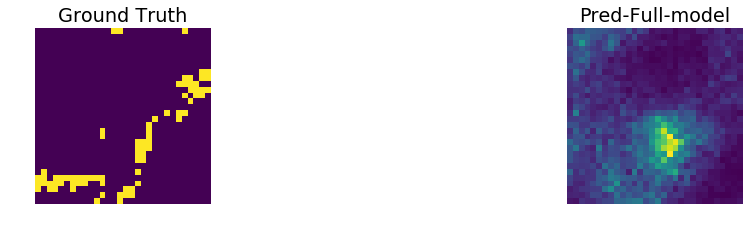

In [75]:
set_fig_settings((FIG_REG_WIDTH*2.5,FIG_REG_WIDTH*5.45))
fig = plt.figure()


for i in range(10):    
    plt.subplot(10,2,1)
    plt.imshow(g_truth[i])
    plt.title('Ground Truth')
    plt.axis('off')

    plt.subplot(10,2,2)
    plt.imshow(preds_full_slice[i])
    plt.title('Pred-Full-model')
    plt.axis('off')
    plt.show()
